# Perform single-cell quality control

>**Note:** 
> We only perform single-cell quality control filtering on **Plate 4 (localhost231120090001)**.

In this notebook, we perform single-cell quality control. To filter the single-cells, we use z-score to find outliers using the values from only one feature at a time. We use features from the AreaShape and Intensity modle to assess the quality of the segmented single-cells:

### Assessing poor nuclei segmentation

Due to high confluence, sometimes nuclei overlap on top of each other, creating highly intense clusters within the Hoechst channel. To identify these nuclei, we use:

- **Nuclei Area:** This metric quantifies the number of pixels in a nucleus segmentation. We detect nuclei that are abnormally large, which likely indicates poor nucleus segmentation where overlapping nuclei are merged into one segmentation. 
- **Nuclei Intensity:** This metric quantifies the total intensity of all pixels in a nucleus segmentation. In combination with abnormally large nuclei, we detect nuclei that are also highly intense, likely indicating that this a group of overlapped nuclei.

### Assessing poor cell segmentation

Also due to high confluence, images with large, intense clusters of cells leads to errors in the segmentation algorithm that causes cells around the cluster to segmented incorrectly. When this happens, a cell is segmented around the same segmentation as the nucleus, giving it the same area which is very small for a normal cardiac fibroblast cell. To detect poorly segmented cells, we use:

- **Cells Area:** This metric quantifies the number of pixels in a cell segmentation. We detect cells that are abnormally small, which likely indicates poor cell segmentation due to high confluence clusters.

## Import libraries

In [1]:
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

## Set paths and variables

In [2]:
# Directory with data
data_dir = pathlib.Path("./data/converted_profiles/")

# Directory to save cleaned data
cleaned_dir = pathlib.Path("./data/cleaned_profiles/")
cleaned_dir.mkdir(exist_ok=True)

# Directory to save qc figures
qc_fig_dir = pathlib.Path("./qc_figures")
qc_fig_dir.mkdir(exist_ok=True)

# Load in plate 4 annotated data
plate_4_df = pd.read_parquet(f"{data_dir}/localhost231120090001_converted.parquet")

# Focus on Plate 4
plate = "localhost231120090001"

# Add plate value to plate_4 which is absent due to error
plate_4_df['Image_Metadata_Plate'] = 'localhost231120090001'

print(plate_4_df.shape)
plate_4_df.head()

(21530, 2016)


,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,Metadata_Image_Count_Cells,Metadata_ImageNumber,Image_Metadata_Plate,Image_Metadata_Site,Image_Metadata_Well,Metadata_Cells_Number_Object_Number,...,Nuclei_Texture_Variance_Hoechst_3_02_256,Nuclei_Texture_Variance_Hoechst_3_03_256,Nuclei_Texture_Variance_Mitochondria_3_00_256,Nuclei_Texture_Variance_Mitochondria_3_01_256,Nuclei_Texture_Variance_Mitochondria_3_02_256,Nuclei_Texture_Variance_Mitochondria_3_03_256,Nuclei_Texture_Variance_PM_3_00_256,Nuclei_Texture_Variance_PM_3_01_256,Nuclei_Texture_Variance_PM_3_02_256,Nuclei_Texture_Variance_PM_3_03_256
0,199.395062,268.792593,193.914743,269.641581,18,1.0,localhost231120090001,f00,B02,4.0,...,2.682473,2.711816,0.417965,0.413393,0.391549,0.385171,1.871388,1.714265,1.808903,1.785609
1,303.540675,350.732143,314.842955,368.939934,18,1.0,localhost231120090001,f00,B02,6.0,...,2.827510,2.799884,0.255611,0.251139,0.280049,0.265307,0.915498,0.914829,0.930071,0.907815
2,700.388506,371.800000,708.112277,380.711178,18,1.0,localhost231120090001,f00,B02,7.0,...,0.867296,0.888812,0.182717,0.181873,0.190170,0.183415,0.789052,0.799555,0.775300,0.771433
3,855.869318,481.075758,877.161009,515.307396,18,1.0,localhost231120090001,f00,B02,8.0,...,2.680820,2.670847,0.379754,0.378857,0.363841,0.348069,2.737748,2.866280,2.822142,2.630111
4,586.624514,509.892023,590.453967,504.113587,18,1.0,localhost231120090001,f00,B02,9.0,...,3.523949,3.555939,0.160312,0.171782,0.161702,0.159216,1.310827,1.325847,1.319233,1.259646


## Identify mis-segmented nuclei from large clusters

### Perform z-scoring to identify nuclei outliers

In [3]:
# Determine z-score using only Nuclei Area and Nuclei Intensity from Nuclei channel
plate_4_df["Z_Score_Area"] = zscore(plate_4_df["Nuclei_AreaShape_Area"])
plate_4_df["Z_Score_Intensity"] = zscore(
    plate_4_df["Nuclei_Intensity_IntegratedIntensity_Hoechst"]
)

# Set a threshold for considering outliers (number of standard deviations away from the mean)
outlier_threshold = 2

# Filter DataFrame for outliers
nuclei_outliers_df = plate_4_df[
    (plate_4_df["Z_Score_Area"].abs() > outlier_threshold)
    & (plate_4_df["Z_Score_Intensity"].abs() > outlier_threshold)
]

# Print outliers to assess how it detected outliers
print(nuclei_outliers_df.shape[0])
# Print the range of outliers
print("Outliers Range:")
print("Area Min:", nuclei_outliers_df['Nuclei_AreaShape_Area'].min())
print("Area Max:", nuclei_outliers_df['Nuclei_AreaShape_Area'].max())
print("Intensity Min:", nuclei_outliers_df['Nuclei_Intensity_IntegratedIntensity_Hoechst'].min())
print("Intensity Max:", nuclei_outliers_df['Nuclei_Intensity_IntegratedIntensity_Hoechst'].max())
nuclei_outliers_df[
    [
        "Nuclei_AreaShape_Area",
        "Nuclei_Intensity_IntegratedIntensity_Hoechst",
        "Image_Metadata_Well",
        "Image_Metadata_Site",
        "Metadata_Nuclei_Location_Center_X",
        "Metadata_Nuclei_Location_Center_Y",
    ]
].sort_values(by="Nuclei_AreaShape_Area", ascending=True).head()

366
Outliers Range:
Area Min: 1917.0
Area Max: 7461.0
Intensity Min: 114.75635938718915
Intensity Max: 644.2570542618632


,Nuclei_AreaShape_Area,Nuclei_Intensity_IntegratedIntensity_Hoechst,Image_Metadata_Well,Image_Metadata_Site,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y
4867,1917.0,176.162951,C02,f12,182.271779,652.666145
1187,1918.0,121.211979,B03,f01,454.406674,98.274765
7683,1918.0,224.599451,D03,f08,748.894682,874.530240
3816,1919.0,124.383810,B08,f09,370.513288,770.952579
1610,1922.0,138.132265,B05,f03,34.138398,629.702393


### Scatter plot of single-cells based on Nuclei Area and Intensity

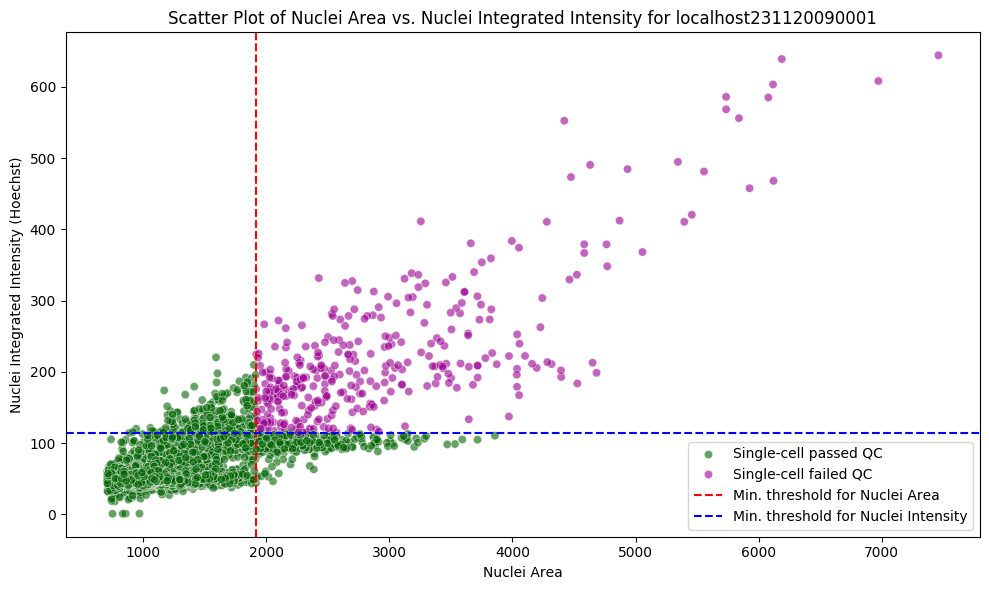

In [4]:
# Set the default value to 'inlier'
plate_4_df['Outlier_Status'] = 'Single-cell passed QC'

# Update the 'Outlier_Status' column based on the outliers DataFrame using index
plate_4_df.loc[plate_4_df.index.isin(nuclei_outliers_df.index), 'Outlier_Status'] = 'Single-cell failed QC'

# Create scatter plot
plt.figure(figsize=(10, 6))
plot = sns.scatterplot(
    data=plate_4_df,
    x="Nuclei_AreaShape_Area",
    y="Nuclei_Intensity_IntegratedIntensity_Hoechst",
    hue="Outlier_Status",
    palette={'Single-cell passed QC': '#006400', 'Single-cell failed QC': '#990090'},  # Specify colors
    alpha=0.6
)

# Add threshold lines
plt.axvline(
    x=1917.0,
    color="r",
    linestyle="--",
    label='Min. threshold for Nuclei Area'
)
plt.axhline(
    y=114.0,
    color="b",
    linestyle="--",
    label='Min. threshold for Nuclei Intensity'
)

plt.title(f"Scatter Plot of Nuclei Area vs. Nuclei Integrated Intensity for {plate}")
plt.xlabel("Nuclei Area")
plt.ylabel("Nuclei Integrated Intensity (Hoechst)")
plt.tight_layout()

# Show the legend
plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0), prop={'size': 10})

# Save figure
plt.savefig(pathlib.Path(f"{qc_fig_dir}/{plate}_nuclei_outliers.png"), dpi=500)

plt.show()


## Identify mis-segmented cells due to high confluence

### Perform z-scoring to identify cells outliers

In [5]:
# Calculate Z-scores for the Cells Area
z_scores = zscore(plate_4_df['Cells_AreaShape_Area'])

# Set a threshold for Z-scores to find outliers that are 1 standard deviation BELOW the mean (which is why it is negative) 
threshold_z = -1

# Identify outlier rows based on Z-scores greater than the mean
cells_outliers_df = plate_4_df[z_scores < threshold_z]

# Print outliers to assess how it detected outliers
print(cells_outliers_df.shape[0])
# Print the range of outliers in the 'Cells_AreaShape_Area' column
print("Outliers Range:")
print("Min:", cells_outliers_df['Cells_AreaShape_Area'].min())
print("Max:", cells_outliers_df['Cells_AreaShape_Area'].max())
cells_outliers_df[
    [
        "Cells_AreaShape_Area",
        "Image_Metadata_Well",
        "Image_Metadata_Site",
        "Metadata_Cells_Location_Center_X",
        "Metadata_Cells_Location_Center_Y",
    ]
].sort_values(by="Cells_AreaShape_Area", ascending=False).head()

3789
Outliers Range:
Min: 708.0
Max: 2410.0


,Cells_AreaShape_Area,Image_Metadata_Well,Image_Metadata_Site,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y
9681,2410.0,D07,f01,684.185477,167.057676
15257,2406.0,F04,f01,668.263924,227.263924
7698,2402.0,D03,f08,865.586178,1033.140716
2950,2402.0,B11,f03,661.450874,1006.398418
11605,2402.0,D08,f07,696.049542,57.010824


### Box plot separating single-cells by outlier status to see the distribution of cells area

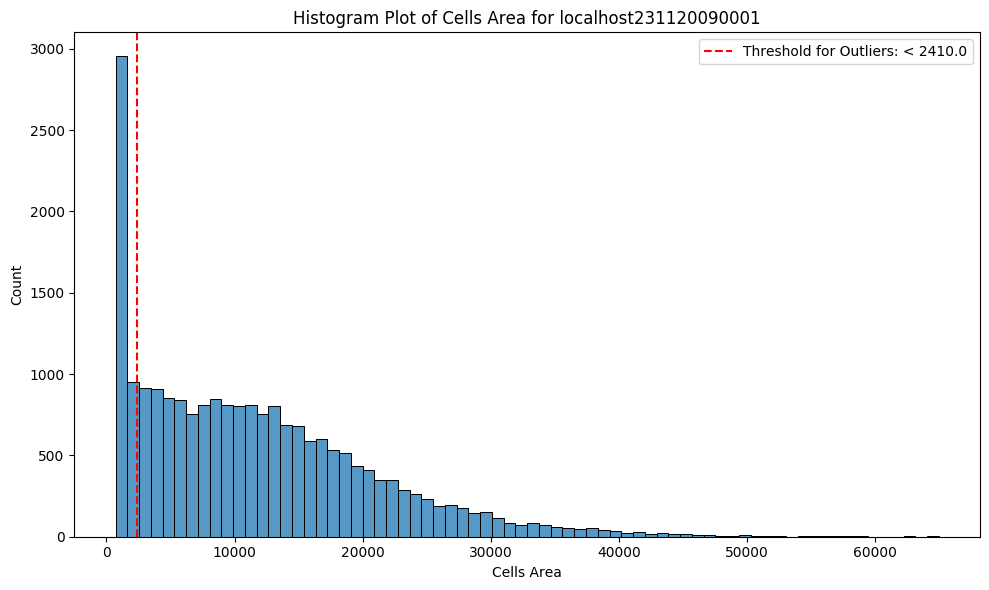

In [9]:
# Create a density plot
plt.figure(figsize=(10, 6))
sns.histplot(x='Cells_AreaShape_Area', data=plate_4_df, fill=True)

# Add threshold line
plt.axvline(
    x=2410.0,
    color="r",
    linestyle="--",
    label='Threshold for Outliers: < 2410.0',
)

# Set labels and title
plt.ylabel('Count')
plt.xlabel('Cells Area')
plt.title(f'Histogram Plot of Cells Area for {plate}')
plt.legend()
plt.tight_layout()

# save figure
plt.savefig(pathlib.Path(f"{qc_fig_dir}/{plate}_cells_outliers.png"), dpi=500)

# Show the plot
plt.show()

## Remove all outliers and save cleaned data frame

In [7]:
# Assuming nuclei_outliers_df and cells_outliers_df have the same index
outlier_indices = pd.concat([nuclei_outliers_df, cells_outliers_df]).index

# Remove rows with outlier indices from plate_4_df
plate_4_df_cleaned = plate_4_df.drop(outlier_indices)

# Remove columns from z-scoring or assigning outliers (not included for downstream analysis)
plate_4_df_cleaned = plate_4_df_cleaned.drop(
    columns=["Z_Score_Area", "Z_Score_Intensity", "Outlier_Status", "is_outlier"],
    errors="ignore",
)

# Save cleaned data for this plate
plate_name = plate_4_df['Image_Metadata_Plate'].iloc[0]
plate_4_df_cleaned.to_parquet(f"{cleaned_dir}/{plate_name}_cleaned.parquet")

# Verify the result
print(plate_4_df_cleaned.shape)
plate_4_df_cleaned.head()

(17389, 2016)


,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,Metadata_Image_Count_Cells,Metadata_ImageNumber,Image_Metadata_Plate,Image_Metadata_Site,Image_Metadata_Well,Metadata_Cells_Number_Object_Number,...,Nuclei_Texture_Variance_Hoechst_3_02_256,Nuclei_Texture_Variance_Hoechst_3_03_256,Nuclei_Texture_Variance_Mitochondria_3_00_256,Nuclei_Texture_Variance_Mitochondria_3_01_256,Nuclei_Texture_Variance_Mitochondria_3_02_256,Nuclei_Texture_Variance_Mitochondria_3_03_256,Nuclei_Texture_Variance_PM_3_00_256,Nuclei_Texture_Variance_PM_3_01_256,Nuclei_Texture_Variance_PM_3_02_256,Nuclei_Texture_Variance_PM_3_03_256
0,199.395062,268.792593,193.914743,269.641581,18,1.0,localhost231120090001,f00,B02,4.0,...,2.682473,2.711816,0.417965,0.413393,0.391549,0.385171,1.871388,1.714265,1.808903,1.785609
1,303.540675,350.732143,314.842955,368.939934,18,1.0,localhost231120090001,f00,B02,6.0,...,2.827510,2.799884,0.255611,0.251139,0.280049,0.265307,0.915498,0.914829,0.930071,0.907815
2,700.388506,371.800000,708.112277,380.711178,18,1.0,localhost231120090001,f00,B02,7.0,...,0.867296,0.888812,0.182717,0.181873,0.190170,0.183415,0.789052,0.799555,0.775300,0.771433
3,855.869318,481.075758,877.161009,515.307396,18,1.0,localhost231120090001,f00,B02,8.0,...,2.680820,2.670847,0.379754,0.378857,0.363841,0.348069,2.737748,2.866280,2.822142,2.630111
4,586.624514,509.892023,590.453967,504.113587,18,1.0,localhost231120090001,f00,B02,9.0,...,3.523949,3.555939,0.160312,0.171782,0.161702,0.159216,1.310827,1.325847,1.319233,1.259646
